# Simpsons classifieur via CNN

## 1. Importations et définitions de fonctions

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import os
import csv
import random

In [24]:
def train_and_save_model(model, epochs, train_ds, val_ds, csv_file_path, model_save_path):
    """
    Fonction pour entraîner un modèle et enregistrer les métriques dans un fichier CSV.

    Arguments :
    model : Modèle à entraîner
    epochs : Nombre d'époques pour l'entraînement du modèle
    train_ds : tf.data.Dataset pour les données d'entraînement
    val_ds : tf.data.Dataset pour les données de validation
    csv_file_path : Chemin où sauvegarder les métriques dans un fichier CSV
    model_save_path : Chemin où sauvegarder le meilleur modèle

    Cette fonction entraîne le modèle avec les données d'entraînement (train_ds) et les données de validation (val_ds).
    Le modèle sauvegarde automatiquement la version ayant la meilleure validation accuracy ('val_accuracy') dans le fichier spécifié par model_save_path.
    Les métriques d'entraînement (accuracy, val_accuracy, loss, val_loss) sont enregistrées dans le fichier CSV spécifié par csv_file_path.
    Utilise l'Early Stopping pour arrêter l'entraînement si la validation accuracy ('val_accuracy') ne s'améliore pas pendant 5 epochs consécutives
    avec une différence minimale de 0.01 entre l'epoch avant le début de la "période patience" et n'importe quelle epoch pendant la "période patience".
    Le callback restaure automatiquement les poids du modèle à l'epoch avec la meilleure validation accuracy.

    """

    # Définition du callback pour arrêter l'entraînement s'il n'y a plus d'amélioration de val_accuracy
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            min_delta = 0.01,
                                            patience=5,
                                            verbose=1,
                                            mode='max',
                                            restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    accuracy_list = history.history['accuracy']
    val_accuracy_list = history.history['val_accuracy']
    loss_list = history.history['loss']
    val_loss_list = history.history['val_loss']

    # Écriture des metrics dans le fichier CSV
    with open(csv_file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Accuracy', 'Val Accuracy', 'Loss', 'Val Loss'])
            writer.writerows(zip(accuracy_list, val_accuracy_list, loss_list, val_loss_list))

    # Sauvegarde du modèle
    model.save(model_save_path)
    print(f"Modèle sauvegardé : {model_save_path}. \n")


In [58]:
def plot_metrics_from_csv(csv_file_path):
    """
    Fonction pour charger les métriques à partir d'un fichier CSV et les tracer avec Matplotlib.

    Arguments :
    csv_file_path : Chemin vers le fichier CSV contenant les métriques.

    Cette fonction lit le fichier CSV spécifié par csv_file_path et trace les courbes d'entraînement et de validation
    pour Accuracy et Loss en fonction du nombre d'époques. Les données sont affichées à l'aide de Matplotlib.
    """

    accuracy_list, val_accuracy_list, loss_list, val_loss_list = [], [], [], []

    # Lecture des données à partir du fichier CSV
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        # Ignorer la première ligne qui contient les noms de colonnes
        next(reader)
        # Parcourir chaque ligne du fichier et stocker les valeurs dans les listes correspondantes
        for row in reader:
            accuracy_list.append(float(row[0]))
            val_accuracy_list.append(float(row[1]))
            loss_list.append(float(row[2]))
            val_loss_list.append(float(row[3]))

    epochs_range = range(1, len(accuracy_list) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy_list, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy_list, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_list, label='Training Loss')
    plt.plot(epochs_range, val_loss_list, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

In [26]:
def predict_images_in_folder(model, folder_path, class_names, img_height, img_width, num_images=5, random_sampling=False):
    """
    Fonction pour prédire les classes sur un dossier d'images et afficher les prédictions pour les premières images.

    Arguments :
    model : Modèle Keras utilisé pour les prédictions.
    folder_path : Chemin du dossier contenant les images à prédire.
    class_names : Liste contenant les noms des classes du modèle.
    img_height : Hauteur de l'image attendue pour la prédiction
    img_width : Largeur de l'image attendue pour la prédiction
    num_images : Nombre d'images à prédire et afficher (par défaut : 5).
    random_sampling : Booléen pour activer ou désactiver l'échantillonnage aléatoire (par défaut : False).

    Cette fonction récupère les images à partir du dossier spécifié, effectue des prédictions de classe pour
    les premières images et affiche chaque image avec sa prédiction correspondante.
    Si random_sampling est True, elle sélectionne un échantillon aléatoire d'images, sinon elle utilise les premières images.
    """

    # Récupérer la liste des noms de fichiers d'images dans le dossier de test
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

    # Sélectionner un échantillon aléatoire d'images ou utiliser toutes les images
    if random_sampling:
        images = random.sample(image_files, min(num_images, len(image_files)))
    else:
        images = image_files[:min(num_images, len(image_files))]

    # Charger et afficher les prédictions pour les images sélectionnées
    for image_file in images:
        # Construire le chemin complet de l'image
        image_path = os.path.join(folder_path, image_file)

        # Charger l'image
        img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Création d'un lot (batch)

        # Prédiction de la classe de l'image à l'aide du modèle
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Affichage de l'image avec la prédiction
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title("{} {:.2f} percent confidence."
                    .format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")
        plt.show()


## 2. Chargement du dataset d'images des personnages

In [6]:
# Variables
batch_size = 32
img_height = 150
img_width = 150

# Chemin du dossier du dataset qui aura la structure suivante :
# - /simpsons_train
#     - /bart_simpson
#           - bart01.jpg
#           - bart02.jpg
#           - ...

#     - /homer_simpson
#           - homer01.jpg
#           - homer02.jpg
#           - ...

#     - /...
data_dir_path = "/content/drive/MyDrive/Simpsons/simpsons_train"

In [7]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_path,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20939 files belonging to 42 classes.
Using 16752 files for training.
Using 4187 files for validation.


In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
42


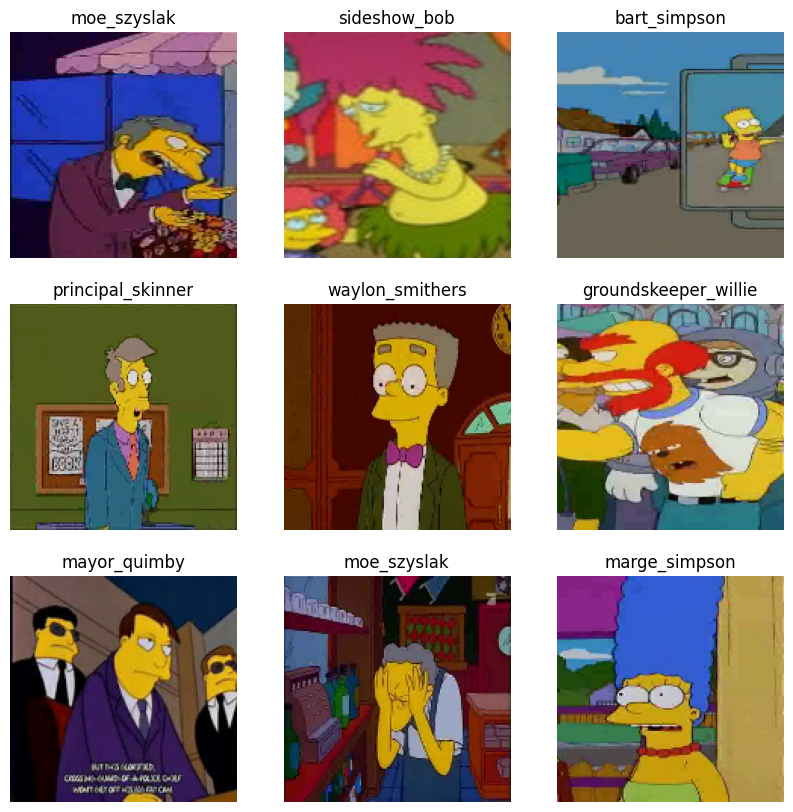

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

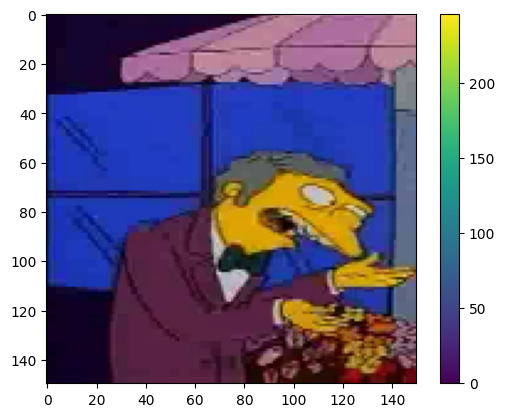

In [10]:
# On regarde si les pixels des images sont déjà normalisés
plt.figure()
plt.imshow(images[0].numpy().astype("uint8"))
plt.colorbar()
plt.grid(False)
plt.show()

In [11]:
# Accélération du fit (utile dans la section suivante)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Entraînement du CNN

### CNN simple

In [29]:
# Nombre total d'epochs à effectuer pendant le fit
epochs_simple = 50

# Chemin vers le fichier CSV
csv_file_path_simple = '/content/drive/MyDrive/Simpsons/modele/metrics_modele_simple.csv'

# Chemin vers la sauvegarde du modèle
model_simple_save_path = '/content/drive/MyDrive/Simpsons/modele/modele_simple.h5'

# Chemin du dossier du dossier à prédire qui aura la structure suivante :
# - /kaggle_simpson_testset
#       - image01.jpg
#       - image02.jpg
#       - image03.jpg
#       - image04.jpg
#       - ...
folder_path = "/content/drive/MyDrive/Simpsons/kaggle_simpson_testset"

# Nombre d'images à prédire et afficher
num_images=5

# Booléen pour activer l'échantillonnage aléatoire des images à prédire
random_sampling=True

In [30]:
# Vérification de l'existence de la sauvegarde du modèle, dans le cas échéant on charge la sauvegarde
if os.path.exists(model_simple_save_path):

    model_simple = tf.keras.models.load_model(model_simple_save_path)
    print(f"Sauvegarde trouvé : {model_simple_save_path}.")
    print("Chargement du modèle dans model_simple. \n")

else:
    # Définition du CNN simple
    model_simple = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

    model_simple.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    print(f"Sauvegarde non trouvé : {model_simple_save_path}.")
    print("Définition du modèle dans model_simple et entraînement. \n")

    # Appeler fonction pour entraîner le modèle et sauvegarder les métriques (définie dans la section 1)
    train_and_save_model(
        model=model_simple,
        epochs=epochs_simple,
        train_ds=train_ds,
        val_ds=val_ds,
        csv_file_path=csv_file_path_simple,
        model_save_path=model_simple_save_path
        )

# Résumé de la structure du CNN
model_simple.summary()

Sauvegarde non trouvé : /content/drive/MyDrive/Simpsons/modele/modele_simple.h5.
Définition du modèle dans model_simple et entraînement. 

Epoch 1/50
524/524 [==============================] - 654s 1s/step - loss: 2.1794 - accuracy: 0.4176 - val_loss: 1.6084 - val_accuracy: 0.5749
Epoch 2/50
524/524 [==============================] - 582s 1s/step - loss: 1.2227 - accuracy: 0.6696 - val_loss: 1.2382 - val_accuracy: 0.6716
Epoch 3/50
524/524 [==============================] - 586s 1s/step - loss: 0.6981 - accuracy: 0.8056 - val_loss: 1.1160 - val_accuracy: 0.7249
Epoch 4/50
524/524 [==============================] - 586s 1s/step - loss: 0.3387 - accuracy: 0.9016 - val_loss: 1.3631 - val_accuracy: 0.7284
Epoch 5/50
524/524 [==============================] - 586s 1s/step - loss: 0.1610 - accuracy: 0.9541 - val_loss: 1.4519 - val_accuracy: 0.7337
Epoch 6/50
524/524 [==============================] - 580s 1s/step - loss: 0.1037 - accuracy: 0.9693 - val_loss: 1.6273 - val_accuracy: 0.7273
Epo

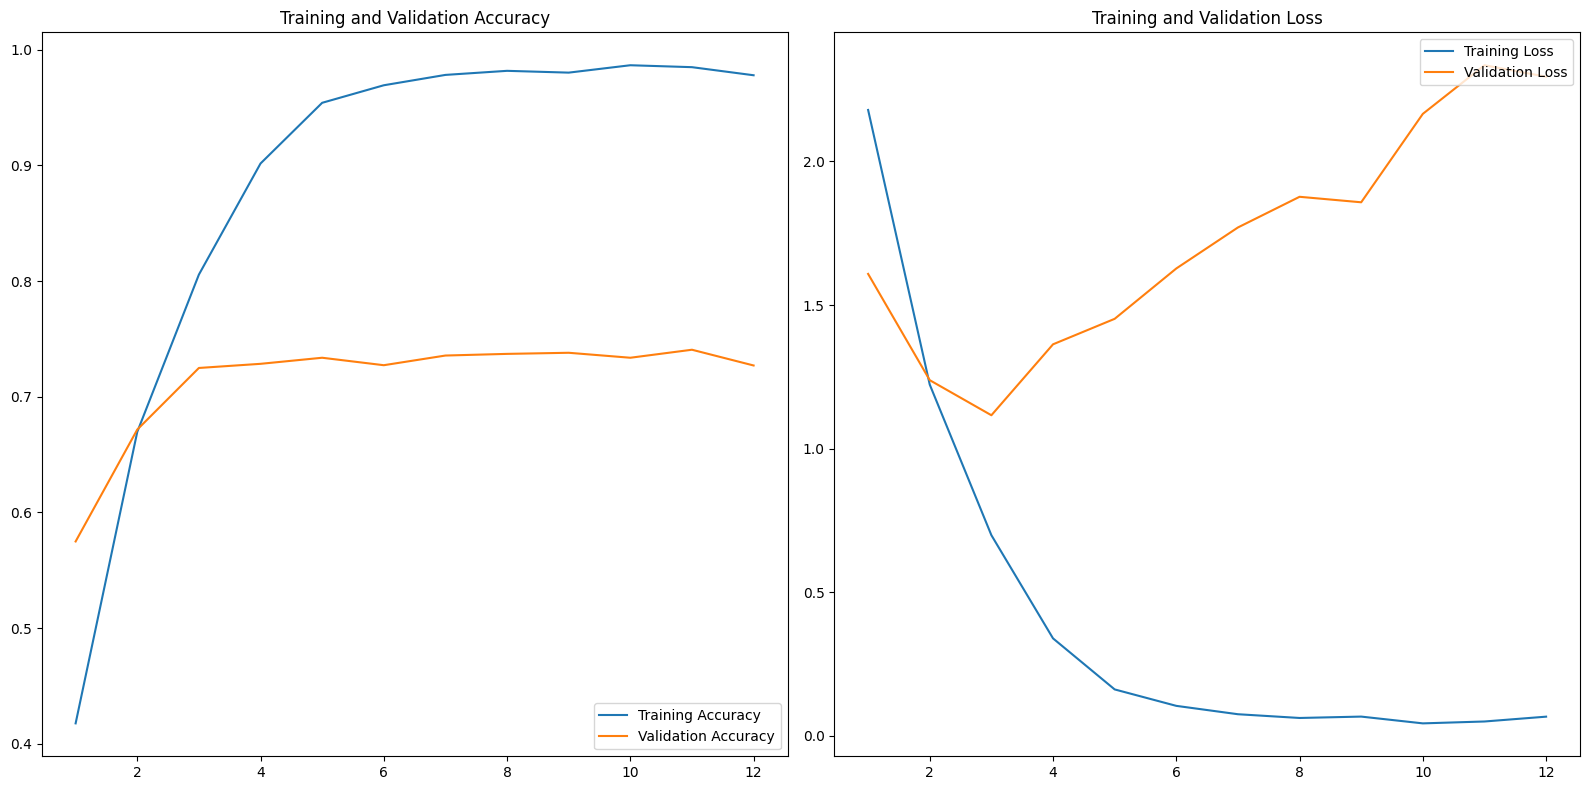

In [59]:
# Appeler fonction pour tracer les accuracy / loss des training dataset et validation dataset (définie dans la sectionn 1)
if os.path.exists(csv_file_path_simple):
    plot_metrics_from_csv(
        csv_file_path=csv_file_path_simple
        )
else:
    print(f"Fichier csv non trouvé : {csv_file_path_simple}. \n")

1/1 [==============================] - 0s 63ms/step


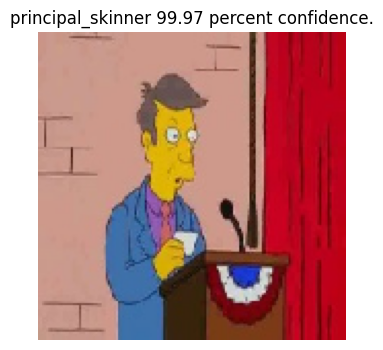

1/1 [==============================] - 0s 48ms/step


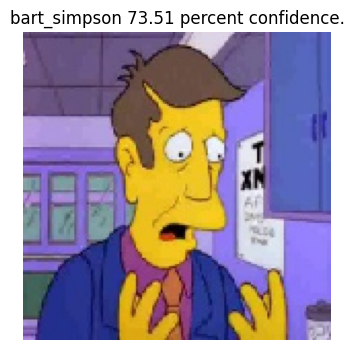

1/1 [==============================] - 0s 58ms/step


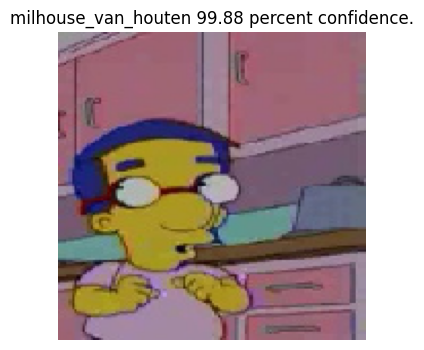

1/1 [==============================] - 0s 33ms/step


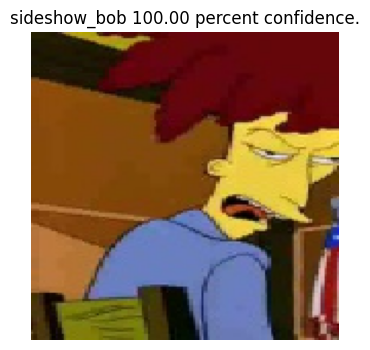

1/1 [==============================] - 0s 36ms/step


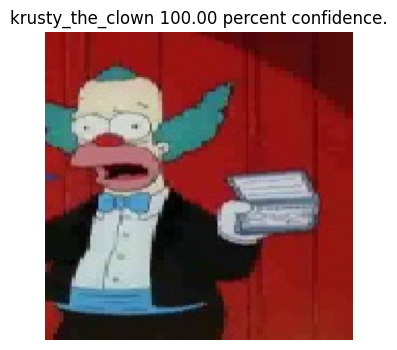

In [69]:
predict_images_in_folder(
    model=model_simple,
    folder_path=folder_path,
    class_names=class_names,
    img_height=img_height,
    img_width=img_width,
    num_images=num_images,
    random_sampling=random_sampling
    )

### CNN avec Data Augmentation et Dropout

In [37]:
# Nombre total d'epochs à effectuer pendant le fit
epochs_dataaugmentation_dropout = 50

# Chemin vers le fichier CSV
csv_file_path_dataaugmentation_dropout = '/content/drive/MyDrive/Simpsons/modele/metrics_modele_dataaugmentation_dropout.csv'

# Chemin vers la sauvegarde du modèle
model_dataaugmentation_dropout_save_path = '/content/drive/MyDrive/Simpsons/modele/modele_dataaugmentation_dropout.h5'

# Chemin du dossier du dossier à prédire qui aura la structure suivante :
# - /kaggle_simpson_testset
#       - image01.jpg
#       - image02.jpg
#       - image03.jpg
#       - image04.jpg
#       - ...
folder_path = "/content/drive/MyDrive/Simpsons/kaggle_simpson_testset"

# Nombre d'images à prédire et afficher
num_images=5

# Booléen pour activer l'échantillonnage aléatoire des images à prédire
random_sampling=True

In [38]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ])

In [39]:
# Vérification de l'existence de la sauvegarde du modèle
if os.path.exists(model_dataaugmentation_dropout_save_path):
    model_dataaugmentation_dropout = tf.keras.models.load_model(model_dataaugmentation_dropout_save_path)
    print(f"Sauvegarde trouvé : {model_dataaugmentation_dropout_save_path}.")
    print("Chargement du modèle dans model_dataaugmentation_dropout. \n")

else:
    # Définition du CNN avec Data Augmentation et Dropout
    model_dataaugmentation_dropout = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

    model_dataaugmentation_dropout.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    print(f"Sauvegarde non trouvé : {model_dataaugmentation_dropout_save_path}.")
    print("Définition du modèle dans model_dataaugmentation_dropout et entraînement. \n")

    # Appeler fonction pour entraîner le modèle et sauvegarder les métriques (définie dans la section 1)
    train_and_save_model(
        model=model_dataaugmentation_dropout,
        epochs=epochs_dataaugmentation_dropout,
        train_ds=train_ds,
        val_ds=val_ds,
        csv_file_path=csv_file_path_dataaugmentation_dropout,
        model_save_path=model_dataaugmentation_dropout_save_path
        )

# Résumé de la structure du CNN
model_dataaugmentation_dropout.summary()

Sauvegarde non trouvé : {model_dataaugmentation_dropout_save_path}.
Définition du modèle dans model_dataaugmentation_dropout et entraînement. 

Epoch 1/50
524/524 [==============================] - 679s 1s/step - loss: 2.2751 - accuracy: 0.3860 - val_loss: 1.8323 - val_accuracy: 0.5178
Epoch 2/50
524/524 [==============================] - 697s 1s/step - loss: 1.5505 - accuracy: 0.5815 - val_loss: 1.3362 - val_accuracy: 0.6406
Epoch 3/50
524/524 [==============================] - 667s 1s/step - loss: 1.2289 - accuracy: 0.6649 - val_loss: 1.1295 - val_accuracy: 0.7024
Epoch 4/50
524/524 [==============================] - 662s 1s/step - loss: 1.0384 - accuracy: 0.7101 - val_loss: 1.0332 - val_accuracy: 0.7153
Epoch 5/50
524/524 [==============================] - 656s 1s/step - loss: 0.9116 - accuracy: 0.7444 - val_loss: 0.8815 - val_accuracy: 0.7595
Epoch 6/50
524/524 [==============================] - 670s 1s/step - loss: 0.7948 - accuracy: 0.7741 - val_loss: 0.9365 - val_accuracy: 0.755

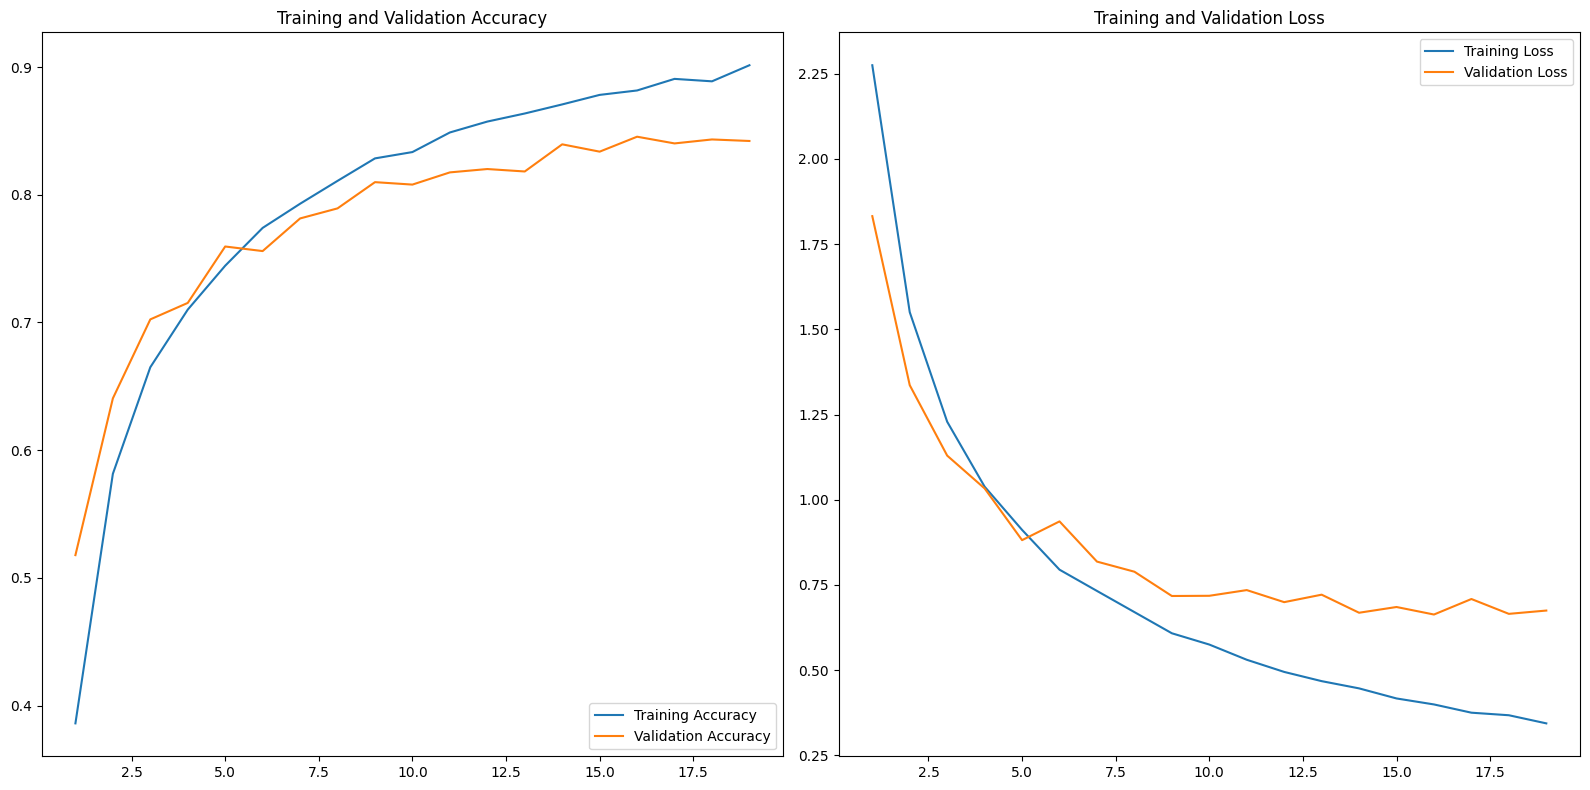

In [60]:
# Appeler fonction pour tracer les accuracy / loss des training dataset et validation dataset (définie dans la section 1)
if os.path.exists(csv_file_path_dataaugmentation_dropout):
    plot_metrics_from_csv(
        csv_file_path=csv_file_path_dataaugmentation_dropout
        )
else:
    print(f"Fichier csv non trouvé : {csv_file_path_dataaugmentation_dropout}. \n")

1/1 [==============================] - 0s 39ms/step


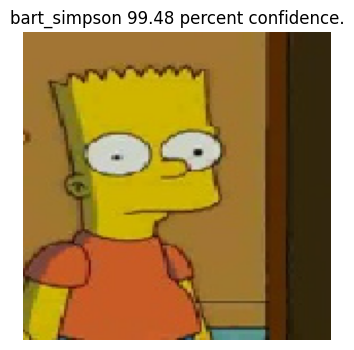

1/1 [==============================] - 0s 39ms/step


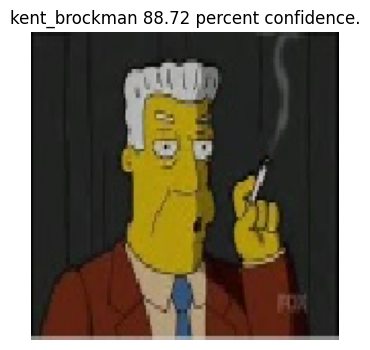

1/1 [==============================] - 0s 35ms/step


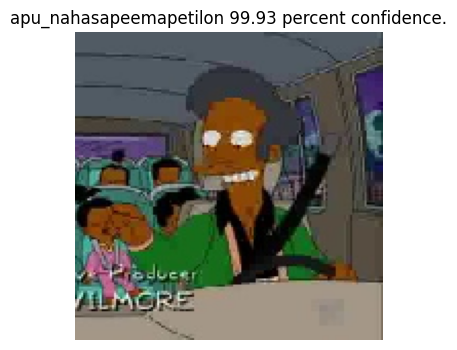

1/1 [==============================] - 0s 39ms/step


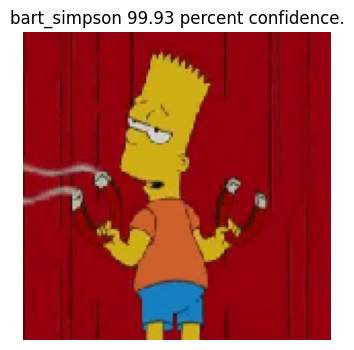

1/1 [==============================] - 0s 33ms/step


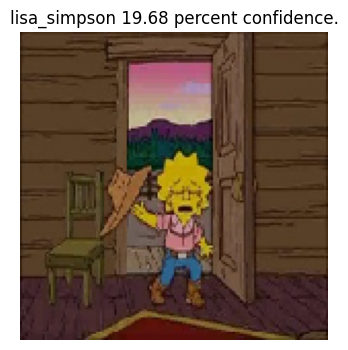

In [70]:
# Appeler fonction pour prédire chaque image du dossier (définie dans la section 1)
predict_images_in_folder(
    model=model_dataaugmentation_dropout,
    folder_path=folder_path,
    class_names=class_names,
    img_height=img_height,
    img_width=img_width,
    num_images=num_images,
    random_sampling=random_sampling
    )

## 4. Évaluation des modèles

In [73]:
test_loss, test_acc = model_simple.evaluate(val_ds, verbose=2)

formatted_test_acc = "{:.2%}".format(test_acc)
formatted_test_loss = "{:.2f}".format(test_loss)

print('\nTest accuracy du CNN simple :', formatted_test_acc)
print('Test loss du CNN simple:', formatted_test_loss)

131/131 - 49s - loss: 1.7701 - accuracy: 0.7356 - 49s/epoch - 374ms/step

Test accuracy du CNN simple : 73.56%
Test loss du CNN simple: 1.77


In [72]:
test_loss, test_acc = model_dataaugmentation_dropout.evaluate(val_ds, verbose=2)

formatted_test_acc = "{:.2%}".format(test_acc)
formatted_test_loss = "{:.2f}".format(test_loss)

print('\nTest accuracy du CNN avec Data Augmentation et Dropout :', formatted_test_acc)
print('Test loss du CNN avec Data Augmentation et Dropout:', formatted_test_loss)

131/131 - 37s - loss: 0.6684 - accuracy: 0.8395 - 37s/epoch - 282ms/step

Test accuracy du CNN avec Data Augmentation et Dropout : 83.95%
Test loss du CNN avec Data Augmentation et Dropout: 0.67
